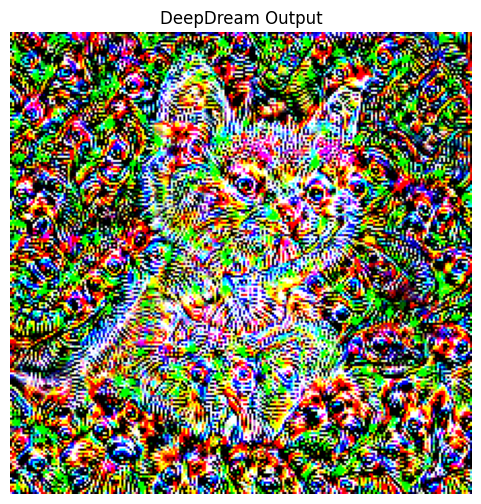

In [12]:
import torch
import torchvision.models as models
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt

# Load and preprocess image
img_path = r"C:\Users\ghwns\Downloads\CAT.jpg"
image = Image.open(img_path)

preprocess = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406],
                [0.229, 0.224, 0.225])
])
img_tensor = preprocess(image).unsqueeze(0)
input_img = img_tensor.clone().detach().requires_grad_(True)

# Load pretrained VGG16
model = models.vgg16(pretrained=True).features.eval()

# Register hook to capture layer activation
features = {}
def hook_fn(module, input, output):
    features['target'] = output

# You can try layer 22, 25, or 28 for stronger effects
target_layer = model[22]
target_layer.register_forward_hook(hook_fn)

# DeepDream function
def deep_dream(img, iterations=50, lr=0.1):
    for _ in range(iterations):
        model.zero_grad()
        model(img)
        loss = features['target'].mean()
        loss.backward()
        grad = img.grad.data
        img.data += lr * grad / (grad.std() + 1e-8)
        img.grad.data.zero_()
    return img

# Apply DeepDream
dreamed_img = deep_dream(input_img, iterations=100, lr=0.15)

# Convert back to image
def deprocess(tensor):
    tensor = tensor.squeeze().detach().cpu()
    tensor = tensor * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    tensor = tensor + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    tensor = tensor.clamp(0, 1)
    return T.ToPILImage()(tensor)

# Show result
result = deprocess(dreamed_img)
plt.figure(figsize=(6, 6))
plt.imshow(result)
plt.axis('off')
plt.title("DeepDream Output")
plt.show()